In [449]:
# Your code here - remember to use markdown cells for comments as well!
import gzip
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import matplotlib.ticker as ticker
%matplotlib inline
!ls zippedData

bom.movie_gross.csv.gz
imdb.name.basics.csv.gz
imdb.title.akas.csv.gz
imdb.title.basics.csv.gz
imdb.title.crew.csv.gz
imdb.title.principals.csv.gz
imdb.title.ratings.csv.gz
rt.movie_info.tsv.gz
rt.reviews.tsv.gz
tmdb.movies.csv.gz
tn.movie_budgets.csv.gz


## Inspecting the contents of the data
    After reading in our dataframes I wanted to see the column for each column in each dataframe to deide what we were gonna pitch as a reason to why a movie is successful. I noticed first that basics_names had professions in it and that struck me as a good place to start. Movies are made people, movies are starred in by people, these would have effective ways to measure success. But I needed something more concrete than just professions, because that was a little too broad. I saw that production budget column name in movie_budgets. This seemed like a good idea to use becuase it was already neatly encapsulated in a dataframe column. It also solved my problem of narrowing down targets, a production budget contains the budget for everything, including all the actors, writers and staff. Unfortunatelly for me there was no immediate connection between the two data frames.

In [326]:
#movies_gross = pd.read_csv("zippedData/bom.movie_gross.csv")
#Titles, Studio, Domestic Gross, Foreign Gross and Year

basics_names = pd.read_csv("zippedData/imdb.name.basics.csv.gz")
#Nconst, Primary Name, Primary Profession, Known for titles(title_id)
#just producers


#akas= pd.read_csv("zippedData/imdb.title.akas.csv")
#Title ID's, Ordering, Title, Region, Language, Types, Attributes, Original Title

basics_titles = pd.read_csv("zippedData/imdb.title.basics.csv.gz")
#Tconst, Primary Title, Original Title, Start Year, Runtime Minutes, Genres

#crew = pd.read_csv("zippedData/imdb.title.crew.csv")
#Tconst, Directors, Writers

#principals = pd.read_csv("zippedData/imdb.title.principals.csv")
#Tconst, Ordering, Nconst, Category, Job, Characters

ratings = pd.read_csv("zippedData/imdb.title.ratings.csv.gz")
#Tconst, Average Rating, Number of Votes

#movies = pd.read_csv("zippedData/tmdb.movies.csv")
#Genre Id, Id, Original Language, Original Language, Original Title, Popularity, Release Date, Title, Vote Average, Vote count

movie_budgets = pd.read_csv("zippedData/tn.movie_budgets.csv.gz")
#Id, Release Date, Movie Name, Production Budget, Domestic Gross, Worldwide Gross

#reviews = pd.read_csv('zippedData/rt.reviews.tsv', sep = '\t', encoding = 'unicode_escape')
#['id', 'review', 'rating', 'fresh', 'critic', 'top_critic', 'publisher','date']

#movie_info = pd.read_csv('zippedData/rt.movie_info.tsv', sep = '\t', encoding = 'unicode_escape')
#['id', 'synopsis', 'rating', 'genre', 'director', 'writer','theater_date', 'dvd_date', 'currency', 'box_office', 'runtime','studio']



#used basics_names, basics_titles, ratings, movie_budgets


# Trimming Down Data
I poked around in the data some more and found a way to link the four big dataframes with all the information I neeeded by merging on their shared content, dropping unused columns, data cleaning, and renaming columns for clarity. I kept a record of the number of columns and rows to asee how much data I lost and make sure it was only things I meant to lose
 My four data frames I used were:
 Basics_names, basics_titles, ratings, movie_budgets


In [482]:
producer = (basics_names.loc[basics_names['primary_profession'] == 'producer'])
#finds only information where the primary profession is equal to producer
#save that data frame in in variable called producer 

producer = producer[producer['known_for_titles'].notna()]
#filters out every NAN in the known for titles column
#only wnat producers who have worked on product
#21492 rows × 6 columns

producer_condensed = producer[['primary_name', 'known_for_titles']]
#condenses down the dataframe to just the infor I want, the two columns with name and titles
#21492 rows × 2 columns

producer_condensed = producer_condensed.rename(columns={'primary_name' : 'producer_name', 'known_for_titles' : 'all_title_ids_unsplit'})
#rename columns for ease of understanding
#21492 rows × 2 columns

producer_condensed['title_id_split']=producer_condensed['all_title_ids_unsplit'].map(lambda x : x.split(','))
#takes the list that contains a single string of comma separated values and separates them so they are iterable
#21492 rows × 3 columns

producer_name_split_title_ids = producer_condensed[['producer_name', 'title_id_split']]
#drops unusable column of unsplit tile ids
#21492 rows × 2 columns

#producer
#producer_condensed
producer_name_split_title_ids

,producer_name,title_id_split
69,G. Robert Blakey,"[tt0094574, tt0206501, tt9412600, tt2281529]"
131,Neil Bregman,"[tt0410055, tt0816539, tt0283805, tt0357585]"
425,Gerry Flahive,"[tt0118858, tt0214822, tt3304616, tt0206501]"
569,Sandra Itkoff,"[tt1083853, tt0497398, tt1377278, tt0795174]"
883,Martin Paul-Hus,"[tt0238994, tt0484881, tt2071465, tt0402378]"
...,...,...
606604,Ashok Reddy Gummakonda,[tt8665746]
606613,Harikumar R.,[tt8688202]
606634,Gary Evans,"[tt0306913, tt8726188]"
606635,Geraldine Caster,[tt8728296]


# Splitting Up Title Ids
 One challenge I had when going through the data was getting all the titles id, the movies, associated with each producer into a usable form. They were read in as a list that contained a single string of comma separated ids. In this form they were unusable to collect the information I needed.

In [483]:
expanded_producer_name_split_title_ids = producer_name_split_title_ids.explode('title_id_split')
#used exploded method to expand known_title_column into mulitpiple rows to be mergeable with title/rating data
#40397 rows × 2 columns

expanded_producer_name_split_title_ids_merge_ratings_raw = expanded_producer_name_split_title_ids.merge(ratings, left_on= 'title_id_split', right_on = 'tconst')
#merges the producer names with their individual title ids with ratings title ids, average ratigns and numvotes
#19092 rows × 5 columns

expanded_producer_name_split_title_ids_ratings = expanded_producer_name_split_title_ids_merge_ratings_raw[['producer_name', 'tconst', 'averagerating']]
#filters out duplicate and unused data
#19092 rows × 3 columns

#expanded_producer_name_split_title_ids
#expanded_producer_name_split_title_ids_merge_ratings_raw
expanded_producer_name_split_title_ids_ratings

,producer_name,tconst,averagerating
0,G. Robert Blakey,tt2281529,8.2
1,Martin Paul-Hus,tt2071465,6.0
2,Giles Edwards,tt9026184,7.0
3,Sudhan Sundaram,tt8011324,7.1
4,Umesh,tt8011324,7.1
...,...,...,...
19087,Burak Memisoglu,tt5522892,3.1
19088,Peter Stylianou,tt2847238,5.7
19089,Ajay Kanayalal Sukheja,tt8620146,6.2
19090,Ashok Reddy Gummakonda,tt8665746,7.0


# Picking the Right Column Name to Merge With
 As I was merging my data between the big dataframes I had to make some decisions on how to preserve the most data possible. The datalink between basics_titles and movie_budgets and my forming personal dataframe is movie titles. In basics_titles comparing the titles in its two title lists to the title list in movie_budgets and seeing which had the highest count of matching titles would preserve the most data.

In [484]:
movie_budgets_movie_list = movie_budgets['movie'].tolist()
basics_title_primary_title_list = basics_titles['primary_title'].tolist()
basics_titles_original_titles_list = basics_titles['original_title'].tolist()
#get list of primary titles and list of original titles from basics titles
#compare against list of title from movie budgets
# basics titles list with most matches is list to use

primary = 0
#a counter for the primary list
original = 0
#a counter for the original list

for title in basics_title_primary_title_list:
    if title in movie_budgets_movie_list:
        primary +=1
#A for loop to count every movie that appears in both basics_titles_primary and movie_budgets
        
for titles in basics_titles_original_titles_list:
    if titles in movie_budgets_movie_list:
        original +=1
#A for loop to count every movie title that appears in both basics_titles_original and movie_budgets
        
#print("primary", primary, "original", original)
# primary = 3606
#original = 3358
#conclusion: use primary_title column in basics titles dataframe


single_producerName_titleIds_ratings_titleNames_raw = expanded_producer_name_split_title_ids_ratings.merge(basics_titles, left_on='tconst', right_on='tconst')
#merged basics titles first beacuse expanded_producer_name_split_title_ids contains title ids,
#Basics contains title ids and movie names and will merge with movie_budgets beacuse they share movies names 
#19092 rows × 8 columns


single_producerName_titleIds_ratings_titleNames = single_producerName_titleIds_ratings_titleNames_raw.drop(['original_title', 'start_year', 'runtime_minutes'], axis=1)
#drops unused columns
#19092 rows × 5 columns

#single_producerName_titleIds_ratings_titleNames_raw
#single_producerName_titleIds_ratings_titleNames_genre_unsplit
single_producerName_titleIds_ratings_titleNames

,producer_name,tconst,averagerating,primary_title,genres
0,G. Robert Blakey,tt2281529,8.2,The Wall Street Conspiracy,Documentary
1,Martin Paul-Hus,tt2071465,6.0,Friends from France,"Adventure,Drama,History"
2,Giles Edwards,tt9026184,7.0,Girl on the Third Floor,Horror
3,Sudhan Sundaram,tt8011324,7.1,Seethakaathi,Drama
4,Umesh,tt8011324,7.1,Seethakaathi,Drama
...,...,...,...,...,...
19087,Burak Memisoglu,tt5522892,3.1,Azazil 2: Büyü,"Horror,Thriller"
19088,Peter Stylianou,tt2847238,5.7,Who Needs Enemies,"Crime,Drama,Thriller"
19089,Ajay Kanayalal Sukheja,tt8620146,6.2,Re Raya,Sport
19090,Ashok Reddy Gummakonda,tt8665746,7.0,Rx 100,"Action,Drama"


# Finding the best list of titles to use for the next merge
The primary title lsit in basics_titles ended up presereving the most data

In [485]:
single_producerName_titleIds_ratings_titleNames_movie_budgets_merge = movie_budgets.merge(single_producerName_titleIds_ratings_titleNames,
left_on = 'movie', right_on= 'primary_title')
#merege movie_budgets with data frame by movie names to release date sand budget, cost , spend
#767 rows × 11 columns

single_date_budget_domGross_worldGross_producer_id_rating_title_genre=single_producerName_titleIds_ratings_titleNames_movie_budgets_merge.drop(['id', 'domestic_gross','movie', ], axis=1)
#dropped columns no longer needed 
#767 rows × 8 columns


#single_producerName_titleIds_ratings_titleNames_movie_budgets_merge
single_date_budget_domGross_worldGross_producer_id_rating_title_genre

,release_date,production_budget,worldwide_gross,producer_name,tconst,averagerating,primary_title,genres
0,"Nov 6, 2015","$300,000,000","$879,620,923",Wolfgang Ramml,tt2379713,6.8,Spectre,"Action,Adventure,Thriller"
1,"May 18, 2012","$220,000,000","$313,477,717",Bennett Schneir,tt1440129,5.8,Battleship,"Action,Adventure,Sci-Fi"
2,"May 14, 2010","$210,000,000","$322,459,006",Michael Costigan,tt0955308,6.6,Robin Hood,"Action,Adventure,Drama"
3,"Nov 21, 2018","$99,000,000","$84,747,441",Michael Costigan,tt0955308,6.6,Robin Hood,"Action,Adventure,Drama"
4,"May 3, 2013","$200,000,000","$1,215,392,272",Wen-ge Xiao,tt1300854,7.2,Iron Man 3,"Action,Adventure,Sci-Fi"
...,...,...,...,...,...,...,...,...
762,"Feb 11, 2011","$40,000","$3,632",Jeff Holtz,tt1716760,3.3,Raymond Did It,Horror
763,"Feb 11, 2011","$40,000","$3,632",Dennis Mengelt,tt1716760,3.3,Raymond Did It,Horror
764,"Feb 11, 2011","$40,000","$3,632",Phyllis Legge Gallisath,tt1716760,3.3,Raymond Did It,Horror
765,"Feb 11, 2011","$40,000","$3,632",Michael Chowanski,tt1716760,3.3,Raymond Did It,Horror


# Converting currency strings to integers
I wanted to find the net income of each producer by subtracting the production budget for each from the world wide income. To do this I had to convert the currency values which were read in as strings into usable integers. Net income, or profit is a good indicator of success.

In [486]:
#convert currency into integers to do math and find the net income 
single_date_budget_domGross_worldGross_producer_id_rating_title_genre['production_budget'] = single_date_budget_domGross_worldGross_producer_id_rating_title_genre['production_budget'].apply(lambda x: x.replace('$', '')).apply(lambda x: x.replace(',', '')).astype(np.int64)
single_date_budget_domGross_worldGross_producer_id_rating_title_genre['worldwide_gross'] = single_date_budget_domGross_worldGross_producer_id_rating_title_genre['worldwide_gross'].apply(lambda x: x.replace('$', '')).apply(lambda x: x.replace(',', '')).astype(np.int64)
#converted worldwide gross and production budget to integers

single_date_budget_domGross_worldGross_producer_id_rating_title_genre['net_income'] = single_date_budget_domGross_worldGross_producer_id_rating_title_genre['worldwide_gross'] - single_date_budget_domGross_worldGross_producer_id_rating_title_genre['production_budget']
#subtracts the produciton budget from worldwide gross income to get the net income of a production
#767 rows × 9 columns

single_date_budget_domGross_worldGross_producer_id_rating_title_genre['rating'] = single_date_budget_domGross_worldGross_producer_id_rating_title_genre['averagerating']
single_date_budget_domGross_worldGross_producer_id_rating_title_genre['title_name'] = single_date_budget_domGross_worldGross_producer_id_rating_title_genre['primary_title']
single_date_budget_domGross_worldGross_producer_id_rating_title_genre

,release_date,production_budget,worldwide_gross,producer_name,tconst,averagerating,primary_title,genres,net_income,rating,title_name
0,"Nov 6, 2015",300000000,879620923,Wolfgang Ramml,tt2379713,6.8,Spectre,"Action,Adventure,Thriller",579620923,6.8,Spectre
1,"May 18, 2012",220000000,313477717,Bennett Schneir,tt1440129,5.8,Battleship,"Action,Adventure,Sci-Fi",93477717,5.8,Battleship
2,"May 14, 2010",210000000,322459006,Michael Costigan,tt0955308,6.6,Robin Hood,"Action,Adventure,Drama",112459006,6.6,Robin Hood
3,"Nov 21, 2018",99000000,84747441,Michael Costigan,tt0955308,6.6,Robin Hood,"Action,Adventure,Drama",-14252559,6.6,Robin Hood
4,"May 3, 2013",200000000,1215392272,Wen-ge Xiao,tt1300854,7.2,Iron Man 3,"Action,Adventure,Sci-Fi",1015392272,7.2,Iron Man 3
...,...,...,...,...,...,...,...,...,...,...,...
762,"Feb 11, 2011",40000,3632,Jeff Holtz,tt1716760,3.3,Raymond Did It,Horror,-36368,3.3,Raymond Did It
763,"Feb 11, 2011",40000,3632,Dennis Mengelt,tt1716760,3.3,Raymond Did It,Horror,-36368,3.3,Raymond Did It
764,"Feb 11, 2011",40000,3632,Phyllis Legge Gallisath,tt1716760,3.3,Raymond Did It,Horror,-36368,3.3,Raymond Did It
765,"Feb 11, 2011",40000,3632,Michael Chowanski,tt1716760,3.3,Raymond Did It,Horror,-36368,3.3,Raymond Did It


# Aggregate Function and First Graph
AFter assembling my big data frame organised by having a sinlge row for each movie in it. I had to collect the data points into appropriate lists and calcualte means and counts for others. Mean and Count were both provided for me but I had to write my own aggregate functions to collect all my pieces of data. The pre-final output consists of a dataframe with 1o columns with the producer name as the index column and 600 rows. Next I woukd plot my first graph which wouuld be the inersection of the producers average production budget, the producers average net income, and a the producers average movie rating. The comparison of the averages is how I will measure my succes of viable producer candidates.


In [487]:


agg_functions= {'release_date': lambda x : x.tolist(),'production_budget': 'mean', 'worldwide_gross' : 'mean', 'tconst': lambda x : x.tolist(), 
                'title_name': lambda x : x.tolist(), 'genres': lambda x : x.tolist(), 'net_income' : 'mean', 
                'averagerating' : 'mean','primary_title' : 'count', 'rating': lambda x : x.tolist()}
producers_averages = single_date_budget_domGross_worldGross_producer_id_rating_title_genre.groupby(single_date_budget_domGross_worldGross_producer_id_rating_title_genre['producer_name']).aggregate(agg_functions)
#,ade aggreagat function to pass, means and collections of lists
#600 rows × 10 columns
producers_averages 

#formatter = ticker.FuncFormatter(lambda x, p: '${:,.2f}'.format(x))

#sns.set_style("ticks")
#sns.scatterplot(data=producers_averages, x="production_budget", y="net_income", hue='averagerating')
#plt.title('Interesection of Average Production Budgets and Average Net Income')
#plt.set_ylabels= ('Average net Income')
#plt.set_xlabels=('Average Production Budget')

#plt.yaxis.set_major_formatter(formatter)


#creates a scatter plot showing the relationship between production budget means and net incomes means for each producer

producers_averages

,release_date,production_budget,worldwide_gross,tconst,title_name,genres,net_income,averagerating,primary_title,rating
producer_name,,,,,,,,,,
Aaron Woolf,"[Sep 30, 2016]",10000000.0,9263940.0,[tt5897002],[Denial],[Documentary],-736060.0,7.40,1,[7.4]
Aashish Singh,"[Dec 20, 2013, Jul 6, 2016]",17500000.0,42356700.5,"[tt1833673, tt4832640]","[Dhoom 3, Sultan]","[Action,Thriller, Action,Drama,Sport]",24856700.5,6.25,2,"[5.4, 7.1]"
Abigail Evans,"[Feb 27, 2015]",180000.0,17503.0,[tt2421956],[Butterfly Girl],[Documentary],-162497.0,8.60,1,[8.6]
Adam Siegel,"[Aug 2, 2013, Feb 26, 2010, Sep 16, 2011, Jun ...",32000000.0,70629913.5,"[tt1272878, tt1385867, tt0780504, tt5834262]","[2 Guns, Cop Out, Drive, Hotel Artemis]","[Action,Comedy,Crime, Action,Comedy,Crime, Cri...",38629913.5,6.55,4,"[6.7, 5.6, 7.8, 6.1]"
Adnan M. Sapci,"[Nov 20, 2015]",1400000.0,5552584.0,[tt3966404],[Mustang],[Drama],4152584.0,7.60,1,[7.6]
...,...,...,...,...,...,...,...,...,...,...
Zarah Shah,"[Feb 23, 1996, Apr 21, 2017]",15000000.0,9352500.5,"[tt2187167, tt2187167]","[Unforgettable, Unforgettable]","[Drama,Romance, Drama,Romance]",-5647499.5,5.50,2,"[5.5, 5.5]"
Zoe Hobson,"[May 28, 2010]",5000000.0,16515203.0,[tt1529567],[Sea Rex 3D: Journey to a Prehistoric World],[Documentary],11515203.0,6.90,1,[6.9]
Zoë Chun-Jung Chen,"[Aug 19, 2011]",15000000.0,59168692.0,[tt1616203],[One Day],"[Drama,Romance,Sci-Fi]",44168692.0,6.00,1,[6.0]


# plot_averages
A function that takes in a data frame and plots the Interesection of Average Production Budgets and Average Net Income. This frame is helpful in locating which producers have the least prduction budget, the highest net income and hightest rating on average. These three metrics will provide a good starting point to start selecting a good candidate. The mid to upper left quandrant of the graph is where the best most likely candidates will be located

,production_budget,net_income,averagerating
producer_name,,,
Aaron Woolf,10000000.0,-736060.0,7.40
Aashish Singh,17500000.0,24856700.5,6.25
Abigail Evans,180000.0,-162497.0,8.60
Adam Siegel,32000000.0,38629913.5,6.55
Adnan M. Sapci,1400000.0,4152584.0,7.60
...,...,...,...
Zarah Shah,15000000.0,-5647499.5,5.50
Zoe Hobson,5000000.0,11515203.0,6.90
Zoë Chun-Jung Chen,15000000.0,44168692.0,6.00


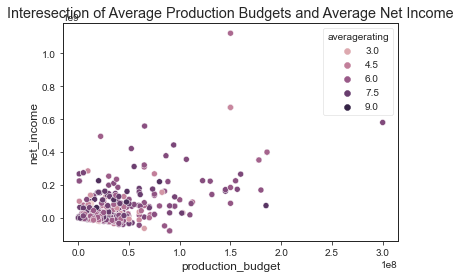

In [488]:
def plot_averages(producers_Averages):
    
    #formatter = ticker.FuncFormatter(lambda x, p: '${:,.2f}'.format(x))
    sns.set_style("ticks")
    sns.scatterplot(data=producers_Averages, x="production_budget", y="net_income", hue='averagerating')
    plt.title('Interesection of Average Production Budgets and Average Net Income')
    plt.set_ylabels= ('Average net Income')
    plt.set_xlabels=('Average Production Budget')
    avg = producers_Averages[['production_budget', 'net_income', 'averagerating']]
    return(avg)

    #plt.yaxis.set_major_formatter(formatter)
    #creates a scatter plot showing the relationship between production budget means and net incomes means for each producer
    
plot_averages(producers_averages)

# The Final Frame
The constuction of my final name requried a column name change for clarity and a function called producer_locate that take a producer name and returns all of their information from the dataframe

In [489]:

final_Frame = producers_averages .rename(columns={'worldwide_gross' : 'gross_income', 'tconst' : 'id',
                                                  'averagerating' : 'mean_rating', 'primary_title' : 'title_count', 'rating' : 'rating_list'})
#renames all of the columns in my final frame for better understanding


#final_Frame.sort_values(['mean_rating'], ascending = False).head(30)
#final_Frame.loc['Audrey Marrs', :]

def producer_locate(name, finalFrame):
    return final_Frame.loc[name, :]
final_Frame

,release_date,production_budget,gross_income,id,title_name,genres,net_income,mean_rating,title_count,rating_list
producer_name,,,,,,,,,,
Aaron Woolf,"[Sep 30, 2016]",10000000.0,9263940.0,[tt5897002],[Denial],[Documentary],-736060.0,7.40,1,[7.4]
Aashish Singh,"[Dec 20, 2013, Jul 6, 2016]",17500000.0,42356700.5,"[tt1833673, tt4832640]","[Dhoom 3, Sultan]","[Action,Thriller, Action,Drama,Sport]",24856700.5,6.25,2,"[5.4, 7.1]"
Abigail Evans,"[Feb 27, 2015]",180000.0,17503.0,[tt2421956],[Butterfly Girl],[Documentary],-162497.0,8.60,1,[8.6]
Adam Siegel,"[Aug 2, 2013, Feb 26, 2010, Sep 16, 2011, Jun ...",32000000.0,70629913.5,"[tt1272878, tt1385867, tt0780504, tt5834262]","[2 Guns, Cop Out, Drive, Hotel Artemis]","[Action,Comedy,Crime, Action,Comedy,Crime, Cri...",38629913.5,6.55,4,"[6.7, 5.6, 7.8, 6.1]"
Adnan M. Sapci,"[Nov 20, 2015]",1400000.0,5552584.0,[tt3966404],[Mustang],[Drama],4152584.0,7.60,1,[7.6]
...,...,...,...,...,...,...,...,...,...,...
Zarah Shah,"[Feb 23, 1996, Apr 21, 2017]",15000000.0,9352500.5,"[tt2187167, tt2187167]","[Unforgettable, Unforgettable]","[Drama,Romance, Drama,Romance]",-5647499.5,5.50,2,"[5.5, 5.5]"
Zoe Hobson,"[May 28, 2010]",5000000.0,16515203.0,[tt1529567],[Sea Rex 3D: Journey to a Prehistoric World],[Documentary],11515203.0,6.90,1,[6.9]
Zoë Chun-Jung Chen,"[Aug 19, 2011]",15000000.0,59168692.0,[tt1616203],[One Day],"[Drama,Romance,Sci-Fi]",44168692.0,6.00,1,[6.0]


In [475]:
name_List = final_Frame.index.tolist()
production_Budget_List= final_Frame['production_budget'].tolist()
gross_Income_List = final_Frame['gross_income'].tolist()
id_List = final_Frame['id'].tolist()
title_List = final_Frame['title_name'].tolist()
genre_List = final_Frame['genres'].tolist()
net_Income_List = final_Frame['net_income'].tolist()
mean_Rating_List =final_Frame['mean_rating'].tolist()
production_Count_List = final_Frame['title_count'].tolist()
rating_List =final_Frame['rating_list'].tolist()
dates_List = final_Frame['release_date'].tolist()

#turning all the data frame information into lists to break down and use later    
    

# movie_rate_grapher
This function takes in a producer name and the final frame. It creates lists of titles, rating and anmes of all the producers, makes the titles and ratings into dictionaries with the names as the keys amd reads the inforation when caleld by the name passed in into a dataframe of usable data for one producers. The information in this personal dataframe is then used to populate a seaborn bar plot that has the movie title as the y axis and its ratings as the x axis. This graphical information allows us to quickly verify if a producer has produced more than one produciton. A signifier that a producer will be able to produce quality content for you is their shown ability to reliably produce content. This means that it would be advisable to select a producer that has at least two movies made with an average rating of at least 6.5

Audrey Marrs,rating,title
0,7.5,Time to Choose
1,8.3,Inside Job


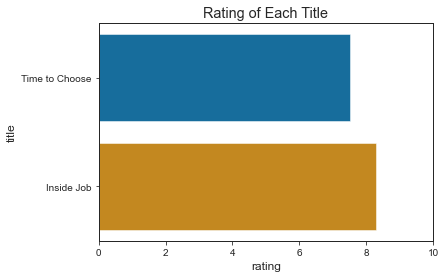

In [476]:
def movie_rate_grapher(name, final_Frame):
    """takes a name and the big data frame and creates a horizontal bar graph 
    for each producer showing the ratings their movies got"""
    
    rating_List =final_Frame['rating_list'].tolist()
    #creats a list of rating
    title_List = final_Frame['title_name'].tolist()
    #creates a list of movie titles
    name_List = final_Frame.index.tolist()
    #creates a lsit of producer nems
    
    
    rating_dict = {name : rating for name, rating in zip(name_List, rating_List)}
    #creates a dictionary with producer names as keys and rating as values
    title_dict = {name : title for name, title in zip(name_List, title_List)}
    #creates a dictionary with producer names as keys and movie titles as values

    rating = rating_dict[name]
    title = title_dict[name]
    #in place values at the dictionary where the name is



    df = pd.DataFrame({'rating' : rating, 'title' : title})
    df = df.rename_axis(name, axis="columns")
    #creates a new data frame containing relevant data to populate graph
    df
    
    #f, ax = plt.subplots(figsize=(10, 10))
    bar = sns.barplot(x = 'rating', y = 'title', data = df, palette="colorblind").set(xlim=(0,10))
    plt.title('Rating of Each Title')
    plt.set_ylabels= ('Each Title Produced')
    plt.set_xlabels=('Rating')
    
    #uses seaborn to create a barplot with the x axis as the ratings and the y axis as the movie titles
    
    return df #returns the dataframe

movie_rate_grapher('Audrey Marrs', final_Frame)

# genre_count_graph
A function that takes a producer name and the final frame and outputs a bar graph showing the count of movies of each genre a producer has produced. The hardest part of this function was splitting up the genre names to get their count as they were much like the title ids from earlier, a list of lists that contain a single string of comma separated words. This function allows us to see graphically which genres each producers has produced the  most work in. this is useful as a metric when combined with Marcos' information on which genres do better in terms of ratings or profit. A consideration to amke when selecting a qualified producer is whether they create popular content in the genre you are intersted in  targeting for your audience or if the genres they do create content in aren't successful in general.

Audrey Marrs,genres,counts
0,Documentary,2
1,Crime,1


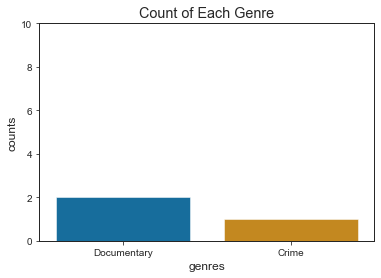

In [477]:
def genre_count_graph(name, finalFrame):
    """Takes in a producer name and outputs a bar graph showing counts of the genres of that each producer produces"""
    flat_genre_List = []
    #creates an empty lsit
    
    name_List = final_Frame.index.tolist()
    #creates a lsit of names from
    genre_Listy = final_Frame['genres'].tolist()
    #creates a list of genres
    #genres are lists of single strings separated by commas
    #strings must be split to collect counts

    
    genre_dict = {name : genre for name, genre in zip(name_List, genre_Listy)}
    #creates a dictionary with the producer name as key adn the list of genres as values
    
    genre = genre_dict[name]
    #creates a list fo genres for desired producer

    
    df1 = pd.DataFrame({'genre' : genre})
    #builds a datafame of idividual producers genre lists
    df1['genre_split'] = df1['genre'].map(lambda x : x.split(','))
    #creates anew column in the dataframe of a list of splits strings
    df1 = df1.drop(['genre'], axis = 1)
    #drops unusable genre column

    
    genre_List = df1['genre_split'].tolist()
    #creates a usable list of genres
    
    for i in genre_List:
        for j in i:
            flat_genre_List.append(j)
    #uses a for loop to get inside the nested list and append each genre found to a flattened list
    

    genre_set = list(set(flat_genre_List))
    #take sthe flattened list and creates a set wrapped in a lsit to get eh unique values
 
    count_dict = {genre:flat_genre_List.count(genre) for genre in flat_genre_List}
    #creates a dictionary where the key is a genre and the value is its count

    
    df = pd.DataFrame({'genres' : list(count_dict.keys()), 'counts' : list(count_dict.values())})
    df = df.rename_axis(name, axis="columns")
    #creates a new dataframe where genres are side by side with their counts but is usabable with seaborn
    
    sns.barplot(x = 'genres', y = 'counts', data = df, palette = "colorblind").set(ylim= (0,10))
    plt.title('Count of Each Genre')
    plt.set_ylabels= ('Counts')
    plt.set_xlabels=('Genres')
    #creates a bar plot with genres as the x axis and teh counts of the genres as the y axis
    
    return df
    



genre_count_graph('Audrey Marrs', final_Frame)

# rating_over_time
a function designed to view the relationship over time of release dates and ratings. THe data is split over years on the x axis with the different color of the poiints illustrating the month the movie was released. This allows us, in conjunction with Svitlana's information about ratings and months to evaluate whether a hgih or low rating when a movie is released might be due to month it was released in. This allows us to evaluate the quality of a producer by taking into consideration average rating might be influenced not by work bu the time it was released.

[1, 2, 3]
[5.0, 5.2, 5.7]


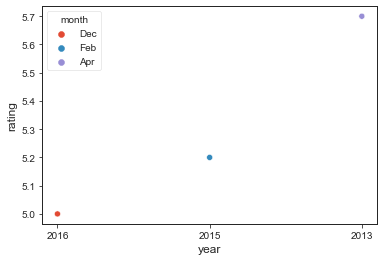

In [478]:
def rating_over_time(name, finalFrame):
    dates_Listy = final_Frame['release_date'].tolist()
    name_List = final_Frame.index.tolist()
    rating_List =final_Frame['rating_list'].tolist()


    
    date_dict = {name : date for name, date in zip(name_List, dates_Listy)}
    #creates a dictionary with the producer name as key adn the list of genres as values
    
    date = date_dict[name]
    #creates a list of dates for desired producer

    
    df1 = pd.DataFrame({'date' : date})
    #builds a datafame of idividual producers date lists
    df1['date_split'] = df1['date'].map(lambda x : x.split(' '))
    #creates a new column in the dataframe of a list of splits strings
    df1 = df1.drop(['date'], axis = 1)
    #drops unusable genre column
    
    dates_List = df1['date_split'].tolist())
    #creates a list of lists of dates separated by spaces like "month, day, year"

    month_List = []
    year_List = []
    #creates an empty list to populate with montha nd year data

    for i in dates_List:
        month_List.append(i[0])
        year_List.append(i[2])
    #uses a for loopto grab just the months and the years

    
    rdict = {name : rating for name, rating in zip(name_List, rating_List)}
    #creates a dictionary 
    ydict = {name : year_List}
    mdict = {name : month_List}


    rating = rdict[name]
    year = ydict[name]
    month = mdict[name]


    
    #x = [*range(1, (len(rating) +1))]
    #print (x)
    
    
    
    df = pd.DataFrame({'rating' : rating, 'year':year, 'month': month})

    sns.scatterplot(data=df, x="year", y="rating", hue = 'month')
    #hue = 'month'
    #sns.lineplot(data=df, x="year", y="rating")

rating_over_time('Amir Delara', final_Frame)
